In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
def load_data(train_dir, val_dir, test_dir):
    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    val_test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
    val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transforms)
    test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

    class_names = train_dataset.classes
    class_counts = [len(list((Path(train_dir) / class_name).glob("*"))) for class_name in class_names]
    class_weights = [1.0 / count for count in class_counts]
    sample_weights = [class_weights[train_dataset.targets[i]] for i in range(len(train_dataset))]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    print(f"Loaded data with {len(class_names)} classes: {class_names}")
    return train_loader, val_loader, test_loader, class_names

In [4]:
def initialize_model(num_classes):
    model = models.resnet50(pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    model = model.to(device)
    return model

In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    train_losses = []
    val_accuracies = []
    val_f1_scores = []
    best_val_acc = 0.0
    best_model_wts = None
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average="weighted")
        val_accuracies.append(val_acc)
        val_f1_scores.append(val_f1)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()
    
    model.load_state_dict(best_model_wts)
    return model, best_val_acc, val_f1, train_losses, val_accuracies, val_f1_scores

In [6]:
def evaluate_model(model, test_loader, class_names):
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
    
    test_acc = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds, average="weighted")
    print("\nClass-wise Performance:")
    print(classification_report(test_labels, test_preds, target_names=class_names))
    return test_acc, test_f1

In [7]:
def plot_metrics(train_losses, val_accuracies, val_f1_scores, num_epochs):
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", color="orange")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_f1_scores, label="Validation F1", color="green")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title("Validation F1 Score")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


Loaded data with 18 classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Grape Brown_Spot', 'Grape Downy_Mildew', 'Grape Mites_Disease', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Mango Gall Midge', 'Mango Powdery Mildew', 'Mango Sooty Mould', 'Peach___Bacterial_spot', 'Peach___healthy']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 194MB/s]


Using 2 GPUs!
Training ResNet50...
Epoch 1/20 - Loss: 1.5589, Val Acc: 0.8667, Val F1: 0.8725
Epoch 2/20 - Loss: 0.5428, Val Acc: 0.9085, Val F1: 0.9148
Epoch 3/20 - Loss: 0.3790, Val Acc: 0.9069, Val F1: 0.9151
Epoch 4/20 - Loss: 0.3288, Val Acc: 0.9106, Val F1: 0.9199
Epoch 5/20 - Loss: 0.2986, Val Acc: 0.9216, Val F1: 0.9255
Epoch 6/20 - Loss: 0.2666, Val Acc: 0.9273, Val F1: 0.9304
Epoch 7/20 - Loss: 0.2661, Val Acc: 0.9283, Val F1: 0.9305
Epoch 8/20 - Loss: 0.2470, Val Acc: 0.9226, Val F1: 0.9270
Epoch 9/20 - Loss: 0.2298, Val Acc: 0.9273, Val F1: 0.9313
Epoch 10/20 - Loss: 0.2198, Val Acc: 0.9313, Val F1: 0.9328
Epoch 11/20 - Loss: 0.2098, Val Acc: 0.9246, Val F1: 0.9296
Epoch 12/20 - Loss: 0.1902, Val Acc: 0.9243, Val F1: 0.9304
Epoch 13/20 - Loss: 0.1864, Val Acc: 0.9240, Val F1: 0.9299
Epoch 14/20 - Loss: 0.1766, Val Acc: 0.9250, Val F1: 0.9292
Epoch 15/20 - Loss: 0.1812, Val Acc: 0.9290, Val F1: 0.9310
Epoch 16/20 - Loss: 0.1748, Val Acc: 0.9229, Val F1: 0.9275
Epoch 17/20 - 

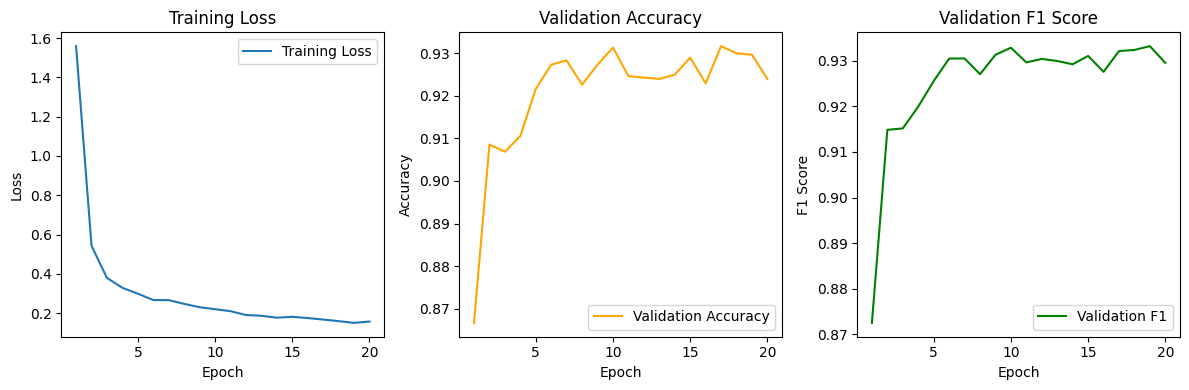


Evaluating ResNet50 on Test Set...

Class-wise Performance:
                                            precision    recall  f1-score   support

                        Apple___Apple_scab       0.99      0.96      0.97       144
                         Apple___Black_rot       0.99      1.00      1.00       125
                  Apple___Cedar_apple_rust       0.92      0.99      0.95        74
                           Apple___healthy       1.00      1.00      1.00       335
  Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       211
         Cherry_(including_sour)___healthy       0.99      1.00      1.00       172
                          Grape Brown_Spot       0.78      0.54      0.64       157
                        Grape Downy_Mildew       0.33      0.76      0.46        79
                       Grape Mites_Disease       0.47      0.70      0.57        80
                         Grape___Black_rot       0.94      0.70      0.80       367
              

In [8]:
def main():
    # Define data directories
    train_dir = "/kaggle/input/splited/train"
    val_dir = "/kaggle/input/splited/val"
    test_dir = "/kaggle/input/splited/test"

    # Load data
    train_loader, val_loader, test_loader, class_names = load_data(train_dir, val_dir, test_dir)

    # Initialize model
    model = initialize_model(num_classes=len(class_names))
    
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = torch.nn.DataParallel(model)
    model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00001)

    # Train the model
    print("Training ResNet50...")
    trained_model, val_acc, val_f1, train_losses, val_accuracies, val_f1_scores = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=20
    )

    # Plot
    print("\nPlotting training metrics...")
    plot_metrics(train_losses, val_accuracies, val_f1_scores, num_epochs=20)  # Fixed num_epochs

    # Evaluate
    print("\nEvaluating ResNet50 on Test Set...")
    test_acc, test_f1 = evaluate_model(trained_model, test_loader, class_names)
    print(f"Test Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}")

    # Save
    torch.save(trained_model.state_dict(), "/kaggle/working/resnet50_leaf_disease.pth")
    print("Model saved to /kaggle/working/resnet50_leaf_disease.pth")
    
if __name__ == "__main__":
    main()